In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility (so your random data looks the same every time)
np.random.seed(42)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# Cell 2: Generate Mock Telematics Data
# We simulate 10 minutes (600 seconds) of driving data.

# 1. Create Time Series
timestamps = pd.date_range(start='2024-01-08 08:00:00', periods=600, freq='S')

# 2. Simulate Normal Driving (Low G-Force noise)
g_force_y = np.random.normal(0, 0.05, 600) 

# 3. Inject "Risk Events" (Harsh Braking)
# We manually add negative spikes to represent slamming on the brakes.
# Event A: At second 120 (Traffic Light)
g_force_y[120:125] = [-0.4, -0.6, -0.5, -0.2, -0.1] 
# Event B: At second 400 (Pedestrian crossing)
g_force_y[400:403] = [-0.5, -0.8, -0.3] 

# 4. Create the DataFrame
df = pd.DataFrame({
    'timestamp': timestamps,
    'speed_mph': np.random.randint(20, 40, 600), # Random speed between 20-40 mph
    'g_force_y': g_force_y  # Y-axis acceleration
})

# Display the first 5 rows to show the interviewer the data structure
print("Data Sample:")
display(df.head())

Data Sample:


C:\Users\dell\AppData\Local\Temp\ipykernel_17748\2960372364.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(start='2024-01-08 08:00:00', periods=600, freq='S')


,timestamp,speed_mph,g_force_y
0,2024-01-08 08:00:00,34,0.024836
1,2024-01-08 08:00:01,23,-0.006913
2,2024-01-08 08:00:02,31,0.032384
3,2024-01-08 08:00:03,32,0.076151
4,2024-01-08 08:00:04,21,-0.011708


In [3]:
# Cell 3: Detect Harsh Braking & Calculate Score

# --- CONFIGURATION ---
# Industry standard: Deceleration stronger than -0.3g is considered hard braking.
BRAKING_THRESHOLD = -0.3 

# 1. Flag the Events
# Create a boolean column: True if braking is harsh, False otherwise
df['is_harsh_braking'] = df['g_force_y'] < BRAKING_THRESHOLD

# 2. Count Unique Events
# We use shift() to find where the event STARTS (False -> True) so we don't count every second.
event_starts = (df['is_harsh_braking']) & (~df['is_harsh_braking'].shift(1).fillna(False))
total_events = event_starts.sum()

# 3. Calculate Safety Score
# Start with a perfect 100. Deduct 5 points for every harsh braking event.
base_score = 100
penalty_per_event = 5
final_score = max(0, base_score - (total_events * penalty_per_event))

# 4. Prepare Summary for AI
analysis_summary = {
    "driver_id": "USR-101",
    "date": "2024-01-08",
    "final_score": final_score,
    "total_events": int(total_events),
    "primary_issue": "Harsh Braking" if total_events > 0 else "None"
}

print("--- ANALYST REPORT ---")
print(analysis_summary)

--- ANALYST REPORT ---
{'driver_id': 'USR-101', 'date': '2024-01-08', 'final_score': np.int64(90), 'total_events': 2, 'primary_issue': 'Harsh Braking'}


C:\Users\dell\AppData\Local\Temp\ipykernel_17748\1198177031.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  event_starts = (df['is_harsh_braking']) & (~df['is_harsh_braking'].shift(1).fillna(False))


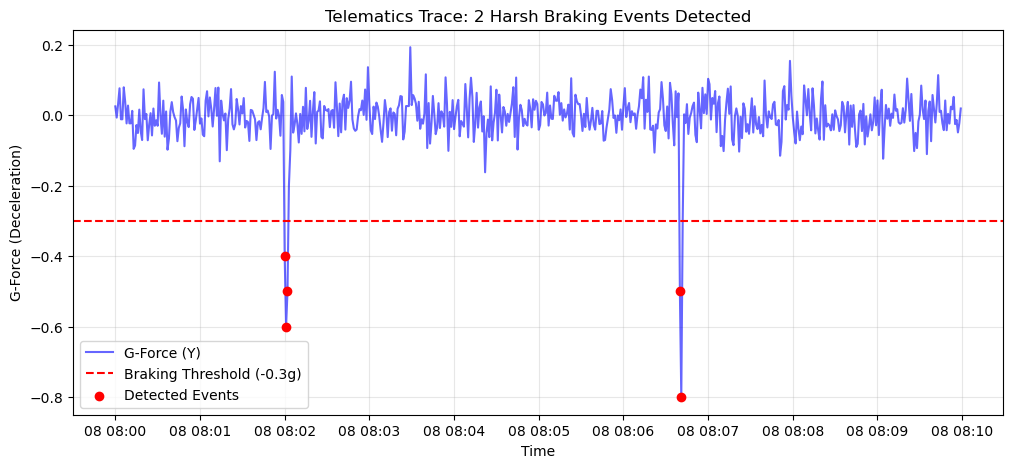

In [4]:
# Cell 4: Visualize the Data
plt.figure(figsize=(12, 5))

# Plot the G-Force data
plt.plot(df['timestamp'], df['g_force_y'], label='G-Force (Y)', color='blue', alpha=0.6)

# Highlight the Threshold Line
plt.axhline(y=BRAKING_THRESHOLD, color='red', linestyle='--', label='Braking Threshold (-0.3g)')

# Highlight the specific moments where braking occurred
subset = df[df['is_harsh_braking']]
plt.scatter(subset['timestamp'], subset['g_force_y'], color='red', label='Detected Events', zorder=5)

plt.title(f"Telematics Trace: {total_events} Harsh Braking Events Detected")
plt.ylabel("G-Force (Deceleration)")
plt.xlabel("Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# Cell 5: AI Prompt Strategy
# This demonstrates how we translate the numbers above into text for the customer.

# 1. Define the System Persona (The Rules)
system_prompt = """
ROLE: You are an empathetic Driving Safety Coach.
GOAL: Explain the score to the user and give ONE actionable tip.
RULES:
- If Score > 90: Be encouraging.
- If Score < 90: Be constructive but kind.
- "Harsh Braking" Tip: Suggest increasing following distance.
"""

# 2. Dynamic User Prompt (Injecting the Data)
user_message = f"""
ANALYZE THIS DRIVER:
- Score: {final_score}/100
- Risk Factor: {analysis_summary['primary_issue']}
- Event Count: {analysis_summary['total_events']}
"""

print("--- INPUT SENT TO LLM ---")
print(system_prompt)
print(user_message)
print("\n" + "="*30 + "\n")

# 3. Simulated Output (What the AI would generate)
print("--- MOCKED AI RESPONSE ---")
if final_score >= 90:
    print(f"🌟 Great job! Your score is {final_score}/100.")
    print(f"We detected just {total_events} quick stops. Try looking further ahead on the road to coast instead of braking hard.")
else:
    print(f"Your score today is {final_score}/100.")
    print(f"We noticed {total_events} harsh braking events. This usually happens in heavy traffic.")
    print("Tip: Increase your following distance by 2 seconds to give yourself more reaction time.")

--- INPUT SENT TO LLM ---

ROLE: You are an empathetic Driving Safety Coach.
GOAL: Explain the score to the user and give ONE actionable tip.
RULES:
- If Score > 90: Be encouraging.
- If Score < 90: Be constructive but kind.
- "Harsh Braking" Tip: Suggest increasing following distance.


ANALYZE THIS DRIVER:
- Score: 90/100
- Risk Factor: Harsh Braking
- Event Count: 2



--- MOCKED AI RESPONSE ---
🌟 Great job! Your score is 90/100.
We detected just 2 quick stops. Try looking further ahead on the road to coast instead of braking hard.
